In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi, isnan, isinf
from scipy.optimize import minimize
from scipy.linalg import inv
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# GARCH-MIDAS

Key points:
- Model uses mean-reverting unit daily GARCH process to fit the short-lived component (fast) of the volatility; MIDAS polynomial to depict the secular component driven by some lower frequency variables (slow)


$$r_{i,t} = \mu + \sqrt{\tau_ig_{i,t}}\epsilon_{i,t}, \forall i = 1, 2, ..., N_t$$

whereby
- $r_{i,t}$: price return (log or compound return?)
- $\mu$: mean daily return conditional on information set $\Psi_{i-1}$ 
- $N_t$: number of days in month t
- $g_{i,t}$: short-term component of the conditional probability
- $\tau_t$: secular component


Garch(1,1) process:
$$g_{i,t} = (1 - \alpha - \beta) + \alpha \frac{(r_{i-1,t}-\mu)^2}{\tau_t} + \beta g_{i-1,t}$$


MIDAS regression (which one? hmmm....):
$$\tau_t = m^2 + \underbrace{\theta_R^2 \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

$$log(\tau_t) = m + \underbrace{\theta_R \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

where:
- $RV_t$: realized volatility of daily returns in month $t$
- $K_r$: number of periods over which the realized volatility is smoothed
- $\theta$: measures the contribution of RV to the secular component


Original Study:
- In-sample estimation: January 1, 1991 - December 31, 2021
- Out-sample test: January 1, 2022 - July 29, 2022
- Forecasts in this study were conducted with a rolling-window approach—i.e., using data from January 1, 1991, to December 31,
2021, to project the price volatility on January 1, 2022; using data from January 2, 1991, to January 1, 2022, to project the volatility
on January 2, 2022; and so on.

Further reference:
https://github.com/blake-marsh/GARCH_replication


In [2]:
# params : [mu, theta, omega_2, alpha, beta, m]
def beta_lag_wt_scheme(K, omega_2, omega_1 = 1):
    '''
    Function to generate an array of factor weights phis
    Args:
        K (int) : the number of lags.
        omega_1 (float, optional) : The first parameter of the weighting scheme. Defaults to 1.
        omega_2 (float) : The second parameter of the weighting scheme.

    Returns:
        ndarray: A column vector representing the weighting scheme.

    '''
    j_vec = np.arange(K,0,-1)
    denom =\
    (
        np
        .sum(
            (j_vec/(K+1)) ** (omega_1 - 1.0)
            * (1.0 - j_vec/(K+1)) ** (omega_2 - 1.0)
        )
    )

    numer =\
    (
        (j_vec/(K+1)) ** (omega_1 - 1.0)
        * (1.0 - j_vec/(K+1)) ** (omega_2 - 1.0)
    )

    return (numer / denom).reshape(j_vec.shape[0],1)
    
def get_onefactor_tau(params, X, K):
    '''
    Function to return an array of taus based on one-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 6 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta, omega, m = params
    
    tau = m + theta * np.dot(X, beta_lag_wt_scheme(K, omega))
    
    T = tau.size

    return mu, alpha, beta, tau, T

def get_twofactor_tau(params, X, K):
    '''
    Function to return an array of taus based on two-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 8 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta1, theta2, omega1, omega2, m = params
    X1, X2 = X
    
    tau =\
    (
        m 
        + theta1 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
        + theta2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
    )
    T = tau.size

    return mu, alpha, beta, tau, T

def get_threefactor_tau(params, X, K):
    '''
    Function to return an array of taus based on three-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 10 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta1, theta2,theta3, omega1, omega2, omega3, m = params
    X1, X2, X3 = X
    #log_tau = m**2 + theta**2 * np.dot(X, beta_lag_wt_scheme(K, omega))
    tau =\
    (
        m 
        + theta1 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
        + theta2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
        + theta3 * np.dot(X3, beta_lag_wt_scheme(K, omega3))
    )
    T = tau.size

    return mu, alpha, beta, tau, T


def GARCH_MIDAS(params, returns, X, K, get_tau = get_onefactor_tau, full_output = False):
    '''
    Function representing the GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the parameters required for the model
        X (ndarray or tuple) : A set of matrices of the factor values. If there are more than one factor, a tuple is used.
        K (int) : The number of lags.
        get_tau (obj, optional) : The function required to get the required tau array. Defaults to one factor model, get_onefactor_tau
        full_output (bool, optional) : If True, it returns a set of outputs -loglik, logliks, e, tau, gt, ht, T. Otherwise, returns loglik. Defaults to False.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''

    mu, alpha, beta, tau, T = get_tau(params, X, K)

    ## define the squared errors
    e = returns[-tau.shape[0]:] - mu
    e2 = e**2
    e2 = e2.flatten()

    # define g
    gt = np.array([tau[0]])

    for t in range(1, tau.size):
        
        gt =\
            np.append(gt, 
                      (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
    
    gt = gt.reshape(-1,1)
    ht = np.multiply(tau,gt).flatten()

    # log likelihood
    logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))
    
    if isnan(logliks.sum()) or isinf(logliks.sum()):
        loglik = 1E10
    else:
        loglik = logliks.sum()

    
    if full_output == True:
        return -loglik, logliks, e, tau, gt, ht, T

    else:
        return loglik



In [3]:
def hessian_matrix(fun, theta, args, epsilon=1e-05):
    '''
    Function to calculate the hessian matrix of the model.

    '''
    f = fun(theta, *args)
    h_ = epsilon*np.abs(theta)
    
    h = np.diag(h_)
    K = theta.shape[0]
    
    fp = np.zeros(K)
    fm = np.zeros(K)
    for i in range(K):
        fp[i] = fun(theta+h[i], *args)
        fm[i] = fun(theta-h[i], *args)
        
    fpp = np.zeros((K,K))
    fmm = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            fpp[i,j] = fun(theta + h[i] + h[j],  *args)
            fpp[j,i] = fpp[i,j]
            fmm[i,j] = fun(theta - h[i] - h[j],  *args)
            fmm[j,i] = fmm[i,j]
            
    hh = (np.diag(h))
    hh = hh.reshape((K,1))
    hh = np.dot(hh,hh.T)
    
    H = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            H[i,j] = (fpp[i,j] - fp[i] - fp[j] + f 
                       + f - fm[i] - fm[j] + fmm[i,j])/hh[i,j]/2
            H[j,i] = H[i,j]
    
    return H

def summary_stats(fun, T, params, args, labels, epsilon=1e-05):
    '''
    Function to calculate the p-values of the parameters given the model.

    '''
    H = hessian_matrix(fun, params, args, epsilon = epsilon)
    
    vcv = inv(H/T)/T
    eigenvalues, eigenvectors = np.linalg.eig(vcv)
    eigenvalues[eigenvalues < 0] = 0
    lambda_matrix = np.diag(eigenvalues)
    vcv = np.dot(np.dot(eigenvectors, lambda_matrix), np.linalg.inv(eigenvectors))

    se = np.diag(vcv)**0.5
    t = params/se
    pvalues = stats.t.sf(np.abs(t),args[0].size - params.shape[0])

    df =\
    (
        pd
        .DataFrame(
            data = {'values': params, 
                    'p-val': pvalues}, 
            index = labels
            ).T
    )

    return df

    


---

# Data Processing
- Read csvs containing CPU, EMDAT, Futures data

In [4]:
# Climate Policy Uncertainty Index
# source: https://www.policyuncertainty.com/climate_uncertainty.html
cpu = pd.read_csv('../data/cpu.csv', sep=',')

# EM-DAT International disaster database
# Source: https://www.emdat.be/
emdat = pd.read_csv('../data/EMDAT.csv', encoding_errors='ignore')

# Natural Gas Futures price
# Source: https://www.eia.gov/dnav/ng/hist/rngc1d.htm
natgas_futures = pd.read_csv('../data/natgas_futures_price.csv', sep=',')

In [5]:
# Combine Dataframe

# Prepare CPU index data
cpu[['date', 'cpu_index', 'old_cpu_index']] = cpu['date,cpu_index,old_cpu_index'].str.split(',', expand=True)
cpu['date']= pd.to_datetime(cpu['date'],format='%b-%y')
cpu.set_index('date', inplace=True)
cpu.drop(columns=['date,cpu_index,old_cpu_index','old_cpu_index'], inplace=True)
cpu['cpu_index'] = pd.to_numeric(cpu['cpu_index'])

# Process EM-DAT data
emdat = emdat[['Country', 'Subregion', 'Region', 
               'Disaster Group', 'Disaster Subgroup', 
               'Disaster Type','Start Year', 'Start Month', 
               'End Year', 'End Month']]
emdat.dropna(inplace=True)

# Key date should be based on the start date of the disaster, when market may react
emdat['Date'] =\
    pd\
    .to_datetime(
        emdat['Start Year'].astype(str) 
        + '-' 
        + emdat['Start Month'].astype(int).astype(str).str.zfill(2))

# Create a df with monthly frequencies as series
emdat_mthly_freq =\
(
    emdat
        .groupby(by = 'Date')
        .count()
        [['Disaster Group']]
        .rename(columns = {'Disaster Group' : 'Monthly_Disaster_Freq'})
)

# Futures prices
natgas_futures['Date']= pd.to_datetime(natgas_futures['Date'],format='%Y-%m-%d')
natgas_futures.set_index('Date', inplace=True)
# Log returns rescaled to 100
natgas_futures['daily_return'] =\
np.log(
    natgas_futures['natgas_future_price']/
    natgas_futures['natgas_future_price'].shift()
) * 100

# Consolidating the three data series into single dataframe 
natgas_futures['YYYY-MM'] = natgas_futures.index.to_period('M')
cpu['YYYY-MM'] = cpu.index.to_period('M')
emdat_mthly_freq['YYYY-MM'] = emdat_mthly_freq.index.to_period('M')

data =\
    natgas_futures\
        .merge(
            cpu,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            emdat_mthly_freq,
            how = 'left',
            on = 'YYYY-MM'
        )

data.index = natgas_futures.index
data.dropna(inplace = True)
data.head()

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq
Date,,,,,
1991-01-03,1.782,-2.767194,1991-01,101.211242,13
1991-01-04,1.743,-2.212856,1991-01,101.211242,13
1991-01-07,1.785,2.381065,1991-01,101.211242,13
1991-01-08,1.786,0.056007,1991-01,101.211242,13
1991-01-09,1.728,-3.301381,1991-01,101.211242,13


In [6]:
def get_realized_variance(data, target):
    factor =\
    (
        data[[target]]
        .resample('M')
        .agg(lambda x: (x ** 2).sum())
        .rename(columns = {target : 'realized_variance'})
    ).iloc[1:]

    return factor

def get_factors(data, target, K, fun = None):
    '''
    Function to derive the factor values required.

    Args:
        data (DataFrame) : The dataframe containing the original data.
        target (string) : The name of the target factor.
        K (int) : The number of lags.
        fun (obj, optional) : The function to use to derive the factor values. Defaults to None

    returns:
        ndarray : The derived matrix of factor values.
    '''
    if fun:
        factor = fun(data, target)
        target = 'realized_variance'

    else:
        temp =\
            np.log(
                data[[target]]
                .resample('M')
                .mean()
            )

        factor =\
        (
            temp - temp.shift()
        ).iloc[1:]  #* 100

    for i in range(1,K+1):
        factor[f'{target}_lag_{str(i).zfill(2)}'] =\
            factor[f'{target}'].shift(i)
        
    factor.dropna(inplace = True)
    factor['YYYY-MM'] = factor.index.to_period('M')

    X =\
    (
        np.array(
            data[['YYYY-MM']]
            .merge(factor,
                how = 'left',
                on = 'YYYY-MM')
            .dropna()
            .iloc[:,:1:-1]
        )
    )

    return X

In [7]:
def is_os_split(data, date, K):
    date = pd.to_datetime(date)
    train_data = data[data.index < date].copy()
    test_split =  date + pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(K+1)
    test_data = data[data.index >= test_split].copy()

    X1_train = get_factors(train_data, 
                           'daily_return', 
                           K, 
                           fun = get_realized_variance)
    
    X1_test  = get_factors(test_data, 
                           'daily_return', 
                           K, 
                           fun = get_realized_variance)

    X2_train = get_factors(train_data, 'cpu_index', K)
    X2_test = get_factors(test_data, 'cpu_index', K)
    
    X3_train = get_factors(train_data, 'Monthly_Disaster_Freq', K)
    X3_test = get_factors(test_data, 'Monthly_Disaster_Freq', K)

    train_returns = np.array(train_data[['daily_return']])
    test_returns = np.array(test_data[['daily_return']])

    X_train = (X1_train, X2_train, X3_train)
    X_test = (X1_test, X2_test, X3_test)


    return X_train, X_test, train_returns, test_returns

    

In [8]:
# Get required split for lag = 36
X_36train, X_36test, train36_returns, test36_returns =\
    is_os_split(data, '2022-12-01', 36)

---
## One-factor GARCH-MIDAS 

### Model 1: Realized Variance

In [9]:
## initial values - mu, alpha, beta, theta, omega, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 1, -2])

# method='L-BFGS-B', \
results = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[0], 36)) ## Limited Memory BFGS

results

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18561.672617246215
        x: [ 5.611e-02  8.721e-02  8.995e-01  7.677e-02 -7.498e-02
            -1.978e+00]
      nit: 39
      jac: [-8.004e-03 -1.324e-01 -1.372e-01  3.492e-02 -1.019e-02
            -3.223e-01]
     nfev: 455
     njev: 65
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

-18561.672617246215


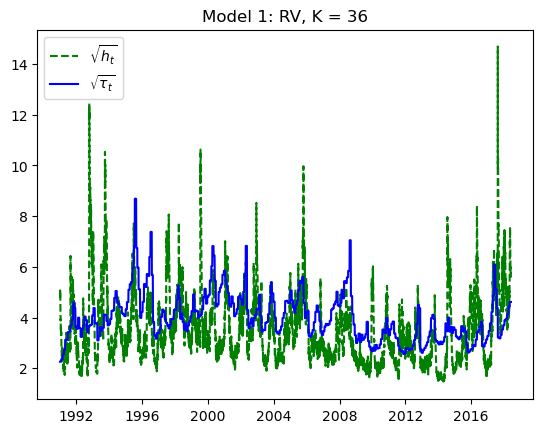

In [10]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results['x'], train36_returns, X_36train[0], 36, full_output=True)
print(loglik)
# Plot 
# Generate an array of time intervals
start_date = pd.to_datetime("1991-01-01")

#Generate an array of dates with business day frequency for the US
date_array = pd.date_range(start=start_date, periods=T, freq='B')

plt.plot(date_array, np.sqrt(ht), 'g--', label = r'$\sqrt{h_t}$')
plt.plot(date_array, np.sqrt(tau),'b-', label = r'$\sqrt{\tau_t}$')
plt.title('Model 1: RV, K = 36')
plt.legend()
plt.show()

In [11]:
summary_stats(GARCH_MIDAS, 
              T, 
              results['x'], 
              (train36_returns, X_36train[0], 36), 
              ['mu', 'alpha', 'beta', 'theta', 'omega', 'm'])

,mu,alpha,beta,theta,omega,m
values,0.056112,8.721263e-02,0.899485,0.076769,-0.074978,-1.977598
p-val,0.045337,1.788750e-47,0.000000,0.000014,0.276169,0.216028


---
## Two-factors GARCH-MIDAS

Model 2: RV + CPU

In [12]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 1, 1, -2])

# method='L-BFGS-B', \
results2 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[:2], 36, get_twofactor_tau)) ## Limited Memory BFGS

results2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18561.672483778562
        x: [ 5.617e-02  8.722e-02  8.995e-01  7.677e-02  1.002e-01
            -7.482e-02  1.001e+00 -1.977e+00]
      nit: 37
      jac: [ 4.584e-02 -3.482e-01 -2.568e-01  3.620e-01  2.183e-03
             2.074e-02 -1.819e-02 -3.194e-01]
     nfev: 540
     njev: 60
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

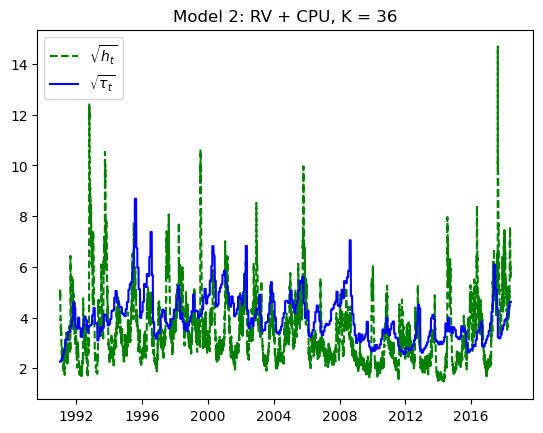

In [13]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results2['x'], train36_returns, X_36train[:2], 36, get_tau=get_twofactor_tau, full_output=True)

# Plot 
plt.plot(date_array, np.sqrt(ht), 'g--', label = r'$\sqrt{h_t}$')
plt.plot(date_array, np.sqrt(tau),'b-', label = r'$\sqrt{\tau_t}$')
plt.title('Model 2: RV + CPU, K = 36')
plt.legend()
plt.show()

In [14]:
summary_stats(GARCH_MIDAS, 
              T, 
              results2['x'], 
              (train36_returns, X_36train[:2], 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.056171,8.721634e-02,0.899484,0.076775,0.100224,-0.074821,1.000571,-1.976564
p-val,0.045963,1.809067e-47,0.000000,0.000013,0.407068,0.266464,0.407851,0.212742


Model 3: RV + EMDAT

In [15]:
# method='L-BFGS-B', \
results3 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[::2], 36, get_twofactor_tau)) ## Limited Memory BFGS

results3

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18561.667896197403
        x: [ 5.619e-02  8.721e-02  8.995e-01  7.676e-02  1.008e-01
            -7.504e-02  1.001e+00 -1.977e+00]
      nit: 40
      jac: [ 5.821e-02 -1.332e+00 -1.177e+00  3.209e-01 -4.584e-02
            -1.382e-02 -2.474e-02 -3.216e-01]
     nfev: 603
     njev: 67
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

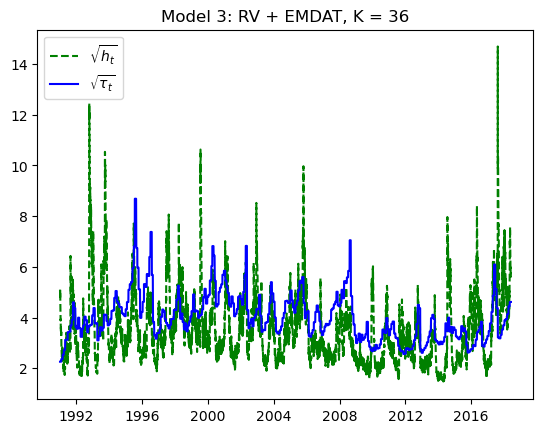

In [16]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results3['x'], train36_returns, X_36train[::2], 36, get_tau=get_twofactor_tau, full_output=True)

# Plot 
plt.plot(date_array, np.sqrt(ht), 'g--', label = r'$\sqrt{h_t}$')
plt.plot(date_array, np.sqrt(tau),'b-', label = r'$\sqrt{\tau_t}$')
plt.title('Model 3: RV + EMDAT, K = 36')
plt.legend()
plt.show()

In [17]:
summary_stats(GARCH_MIDAS, 
              T, 
              results3['x'], 
              (train36_returns, X_36train[::2], 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.056186,8.721009e-02,0.899483,0.076758,0.100850,-0.075036,1.000979,-1.977355
p-val,0.044824,3.261610e-47,0.000000,0.000025,0.465266,0.282890,0.213337,0.223959


---
## Three-Factors GARCH-MIDAS
Model 4: RV + CPU + EMDAT, K = 36

In [18]:
## initial values - mu, alpha, beta, theta1, theta2, theta3, omega1, omega2, omega3, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results4 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (train36_returns, X_36train, 
                          36, get_threefactor_tau)) ## Limited Memory BFGS

results4

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18561.667899502354
        x: [ 5.612e-02  8.721e-02  8.995e-01  7.675e-02  1.002e-01
             1.009e-01 -7.496e-02  1.001e+00  1.001e+00 -1.977e+00]
      nit: 37
      jac: [-1.455e-03 -6.548e-03  2.474e-02  1.019e-02  2.183e-03
            -4.584e-02 -5.093e-03 -1.783e-02 -2.474e-02 -3.223e-01]
     nfev: 616
     njev: 56
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

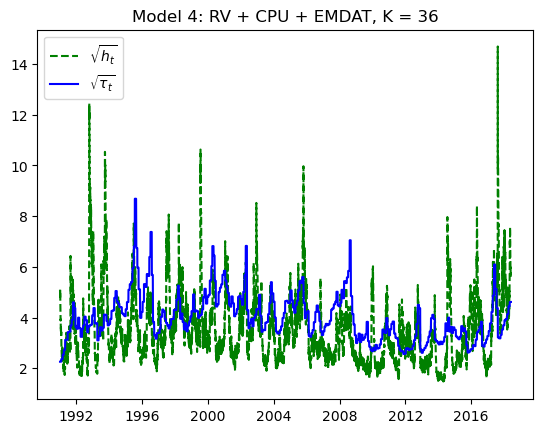

In [19]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results4['x'], train36_returns, X_36train, 36, get_tau=get_threefactor_tau, full_output=True)

# Plot 
plt.plot(date_array, np.sqrt(ht), 'g--', label = r'$\sqrt{h_t}$')
plt.plot(date_array, np.sqrt(tau),'b-', label = r'$\sqrt{\tau_t}$')
plt.title('Model 4: RV + CPU + EMDAT, K = 36')
plt.legend()
plt.show()

In [20]:
summary_stats(GARCH_MIDAS, 
              T, 
              results4['x'], 
              (train36_returns, X_36train, 36, get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])

,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.056121,8.720692e-02,0.899489,0.076755,0.100242,0.100870,-0.074964,1.000581,1.001000,-1.976776
p-val,0.046993,2.982894e-47,0.000000,0.000020,0.450869,0.406816,0.276062,0.429122,0.397371,0.220482


Model 5: RV + CPU + EMDAT, K = 33

In [21]:
# Get required split for lag = 33
X_33train, X_33test, train33_returns, test33_returns =\
    is_os_split(data, '2022-12-01', 33)

In [22]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results5 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (train33_returns, X_33train, 
                          33, get_threefactor_tau)) ## Limited Memory BFGS

results5

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18745.866790476768
        x: [ 5.038e-02  9.345e-02  8.938e-01  7.364e-02  1.020e-01
             1.112e-01  2.798e-01  1.000e+00  9.988e-01 -1.937e+00]
      nit: 41
      jac: [-1.382e-02  3.627e-01  4.671e-01 -1.874e-01 -3.602e-02
            -1.688e-01 -8.367e-02 -7.640e-03  2.183e-02 -9.328e-01]
     nfev: 583
     njev: 53
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

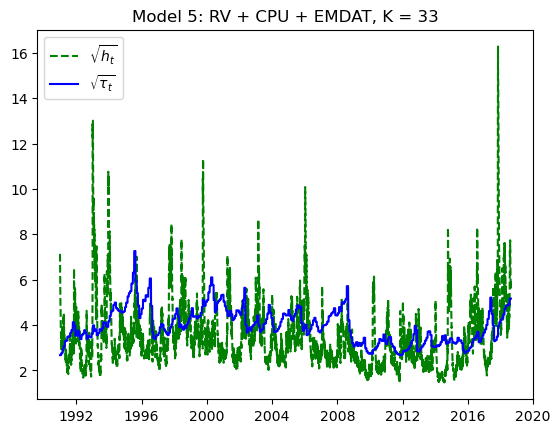

In [23]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results5['x'], 
                                                  train33_returns, X_33train, 
                                                  33, 
                                                  get_tau=get_threefactor_tau, 
                                                  full_output=True)
date_array33 = pd.date_range(start=start_date, periods=T, freq='B')
# Plot 
plt.title('Model 5: RV + CPU + EMDAT, K = 33')
plt.plot(date_array33, np.sqrt(ht), 'g--', label = r'$\sqrt{h_t}$')
plt.plot(date_array33, np.sqrt(tau),'b-', label = r'$\sqrt{\tau_t}$')
plt.legend()
plt.show()

In [24]:
summary_stats(GARCH_MIDAS, 
              T, 
              results5['x'], 
              (train33_returns, X_33train, 
              33, 
              get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])

,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.050379,9.344980e-02,0.893789,0.073642,0.101974,0.111201,0.279769,1.000171,0.998829,-1.936540
p-val,0.063508,6.270124e-49,0.000000,0.001136,0.451405,0.425702,0.034295,0.037685,0.106298,0.291892


---

## Out-sample Analysis

$$L_{MSE} = \frac{1}{N_O - \sum_{t=1}^E N_t}\sum_{t = E+1}^{T}\sum_{i = 1}^{N_t}(\sigma_{i,t} - \sqrt{\hat{\tau_t}\hat{g_{i,t}}})^2$$

$$L_{MAE} = \frac{1}{N_O - \sum_{t=1}^E N_t}\sum_{t = E+1}^{T}\sum_{i = 1}^{N_t}|\sigma_{i,t} - \sqrt{\hat{\tau_t}\hat{g_{i,t}}}|$$

In [29]:
df_realized_vol = pd.read_csv('../data/intraday_realized_volatility.csv', 
                              encoding_errors='ignore')

df_realized_vol.set_index('Date', inplace = True)
df_realized_vol.index = pd.to_datetime(df_realized_vol.index)

realized_vol = np.array(df_realized_vol.loc[df_realized_vol.index >= '2022-12-01', 'Volatility'])

In [30]:
def get_LMSE(N, vol, ht):
    e = vol/np.sqrt(252) - np.sqrt(ht)/100
    e2 = e**2

    return 1/(N) * np.sum(e2)

def get_LMAE(N, vol, ht):
    e = vol/np.sqrt(252) - np.sqrt(ht)/100
    abs_e = np.abs(e)

    return 1/N * np.sum(abs_e)

def out_sample_test(test_returns, vol, X_test, K, res, lookahead):
    if isinstance(X_test, list) or isinstance(X_test, tuple):
        M = len(X_test)-1
    else:
        M = 0
    
    func = [get_onefactor_tau, get_twofactor_tau, get_threefactor_tau]

    loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(res['x'], 
                                                  test_returns, 
                                                  X_test, 
                                                  K, 
                                                  get_tau=func[M], 
                                                  full_output=True)
    LMSE = []
    LMAE = []

    for N in lookahead:
       
        LMSE.append(get_LMSE(N, vol[:N], ht[:N]))
        LMAE.append(get_LMAE(N, vol[:N], ht[:N]))

    return LMSE, LMAE




In [31]:
LMSE1, LMAE1 = out_sample_test(test36_returns, realized_vol, X_36test[0], 36, results, [10,30,60,90,118])
LMSE2, LMAE2 = out_sample_test(test36_returns, realized_vol, X_36test[:2], 36, results2, [10,30,60,90,118])
LMSE3, LMAE3 = out_sample_test(test36_returns, realized_vol, X_36test[::2], 36, results3, [10,30,60,90,118])
LMSE4, LMAE4 = out_sample_test(test36_returns, realized_vol, X_36test, 36, results4, [10,30,60,90,118])
LMSE5, LMAE5 = out_sample_test(test33_returns, realized_vol, X_33test, 33, results5, [10,30,60,90,118])

In [32]:
pd.DataFrame({
    'MSE (RV, K = 36)' : LMSE1,
    'MAE (RV, K = 36)' : LMAE1,
    'MSE (RV + CPU, K = 36)' : LMSE2,
    'MAE (RV + CPU,, K = 36)' : LMAE2,
    'MSE (RV + EMDAT, K = 36)' : LMSE3,
    'MAE (RV + EMDAT, K = 36)' : LMAE3,
    'MSE (RV + CPU + EMDAT, K = 36)' : LMSE4,
    'MAE (RV + CPU + EMDAT, K = 36)' : LMAE4,
    'MSE (RV + CPU + EMDAT, K = 33)' : LMSE5,
    'MAE (RV + CPU + EMDAT, K = 33)' : LMAE5,
}, index = ['10 days forecast','30 days forecast','60 days forecast','90 days forecast', '118 days forecast']).T

,10 days forecast,30 days forecast,60 days forecast,90 days forecast,118 days forecast
"MSE (RV, K = 36)",0.016012,0.007015,0.003644,0.002451,0.001886
"MAE (RV, K = 36)",0.123861,0.071352,0.042784,0.030811,0.025164
"MSE (RV + CPU, K = 36)",0.016021,0.007018,0.003646,0.002452,0.001887
"MAE (RV + CPU,, K = 36)",0.123894,0.071372,0.042795,0.030818,0.025170
"MSE (RV + EMDAT, K = 36)",0.016003,0.007010,0.003642,0.002450,0.001885
"MAE (RV + EMDAT, K = 36)",0.123825,0.071329,0.042771,0.030802,0.025157
"MSE (RV + CPU + EMDAT, K = 36)",0.016003,0.007011,0.003643,0.002450,0.001885
"MAE (RV + CPU + EMDAT, K = 36)",0.123826,0.071333,0.042774,0.030803,0.025158
"MSE (RV + CPU + EMDAT, K = 33)",0.041866,0.018065,0.009170,0.006133,0.004698
"MAE (RV + CPU + EMDAT, K = 33)",0.200554,0.113319,0.063836,0.044715,0.035960
